In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

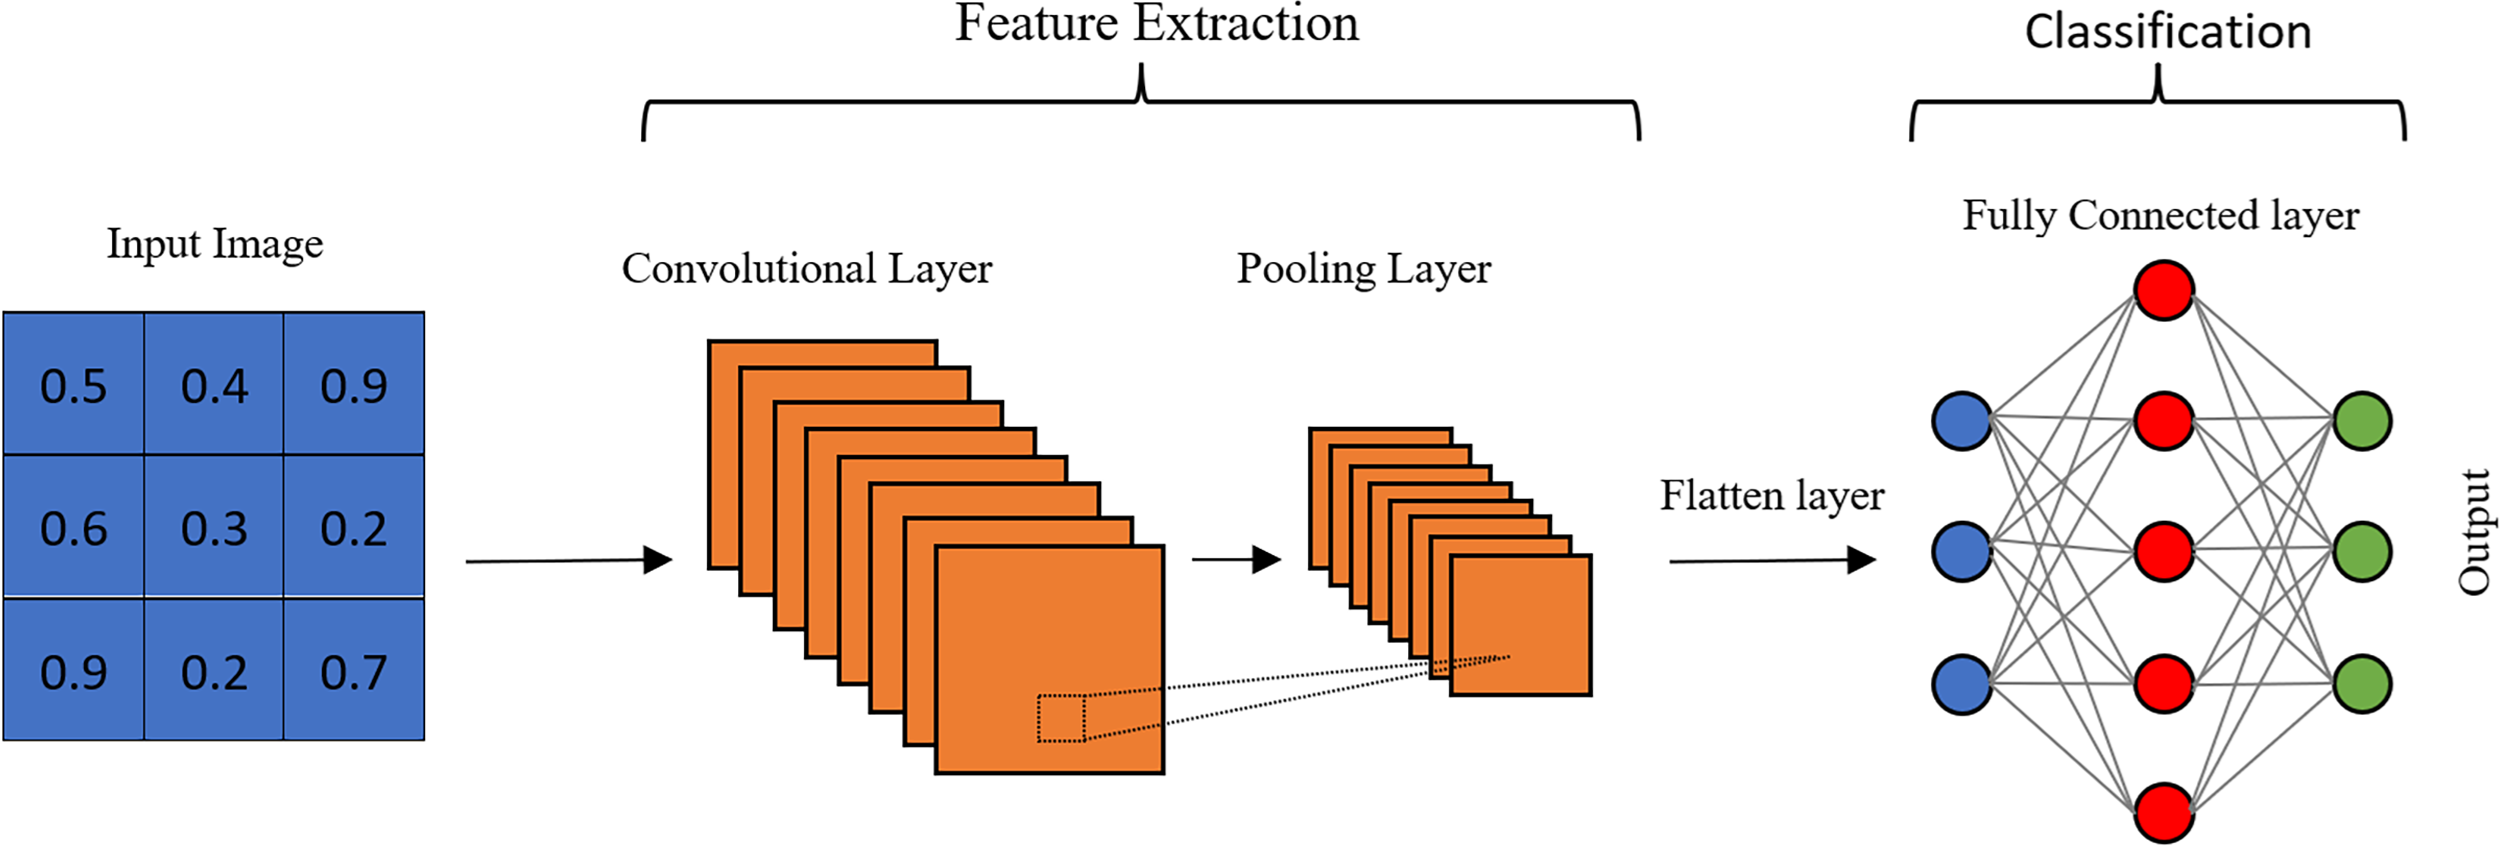

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Lecture Notes & Study Materials/Neural Network & Deeplearning/cnn.png')

# 🧠 Introduction to Convolutional Neural Networks (CNNs) using PyTorch

Convolutional Neural Networks (CNNs) are a special type of deep learning model designed to process data with a grid-like structure, such as images. CNNs are widely used in applications like image classification, object detection, and facial recognition.

A CNN typically works in **two major stages**:

---

## 🔍 1. Feature Extraction (Convolution + Pooling)

When we feed an image into a CNN, it doesn’t try to understand the entire image at once. Instead, it focuses on identifying **important patterns or features** within small regions.

- **Convolution Layer**: Applies filters to detect patterns like **edges**, **curves**, or **textures** in the image. These filters slide across the image and highlight specific features.

- **ReLU Activation**: Introduces non-linearity, keeping strong activations and ignoring weak ones.

- **Pooling Layer (e.g., Max Pooling)**: Reduces the size of the feature maps to make computation efficient and focus on the most dominant features.

As we go deeper:
- First layers detect simple patterns (edges, lines)
- Later layers detect complex features (eyes, faces, objects)

The result of this stage is a **feature map** – a simplified, abstract version of the original image.

---

## 🧮 2. Classification using Artificial Neural Network (ANN)

Once we extract features from the image, we **flatten** the feature maps into a 1D vector and pass them into a regular ANN (also called fully connected layers).

- These layers process the features and output **probabilities for each class**.

For example, in a digit classification task:


Here, the model is **87% confident** the image is a "**7**".

---

## 🧾 Example: MNIST Digit Classification (e.g., '7')

Step-by-step flow:
1. **Input**: 28x28 grayscale image of digit ‘7’
2. **Convolution**: Filters extract edges of the digit
3. **ReLU Activation**: Keeps strong activations
4. **Pooling**: Reduces image size (e.g., from 28x28 → 14x14 → 7x7)
5. **Flattening**: Convert 2D feature map to 1D vector
6. **Fully Connected Layer (ANN)**: Classifies the digit
7. **Output**: Predicts the class (e.g., “7”)

---

## ✅ Summary

> CNN acts as a **feature extractor** that understands what’s important in an image, and ANN is the **decision-maker** that tells us what the image represents.

In the upcoming sections, we will implement this entire pipeline using **PyTorch** on real image datasets.

---


## 🔄 Workflow Overview

We will follow a structured approach to understand and implement CNNs using PyTorch on the **Fashion MNIST** dataset:

1. 📥 **Load Fashion MNIST Dataset**  
   - Download and preprocess the dataset  
   - Visualize some sample images

2. 🧠 **Build a Basic CNN Model**  
   - Implement a simple CNN architecture from scratch  
   - Train and evaluate its performance

3. ⚙️ **Optimize Hyperparameters**  
   - Tune learning rate, batch size, number of filters, etc.  
   - Use validation accuracy and loss to guide the tuning

4. 🔁 **Transfer Learning (Pretrained CNN)**  
   - Apply transfer learning using a pretrained CNN model  
   - Fine-tune on Fashion MNIST to boost accuracy with fewer resources

---

This workflow will help you go from basic CNN understanding to building optimized and production-ready models.


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Convert images to PyTorch tensors and then we normalize pixel values to [-1, 1]
#Resize operation can also be done.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
from torch.utils.data import Subset

# Download and load the training dataset
train_dataset = datasets.FashionMNIST(
    root='/content/gdrive/MyDrive/Lecture Notes & Study Materials/Practical Deep Learning using Pytorch/fashion_mnist',     # directory to store the data
    train=True,        # load training data
    download=True,     # download if not already downloaded
    transform=transform  # apply transform
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='/content/gdrive/MyDrive/Lecture Notes & Study Materials/Practical Deep Learning using Pytorch/fashion_mnist',
    train=False,
    download=True,
    transform=transform
)
#Selecting 6000 instances for training
train_dataset= Subset(train_dataset, indices=range(6000))

#Selecting 6000 instances for training
test_dataset= Subset(train_dataset, indices=range(500))

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.29MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.5MB/s]


In [ ]:
label_names = [
    "T-shirt/top",  # 0
    "Trouser",      # 1
    "Pullover",     # 2
    "Dress",        # 3
    "Coat",         # 4
    "Sandal",       # 5
    "Shirt",        # 6
    "Sneaker",      # 7
    "Bag",          # 8
    "Ankle boot"    # 9
]

Label: 3
It is a : Dress


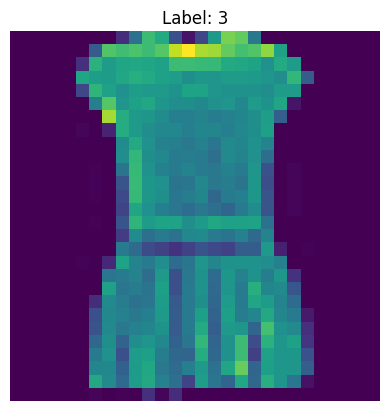

In [ ]:
import matplotlib.pyplot as plt

def show_image(index):

    # Get a single sample using __getitem__
    img, label = train_dataset[index]  # change index as needed

    print("Label:", label)  # will print the class index (0–9)
    print("It is a :", label_names[label])

    # Plot the image (it's a single-channel grayscale)
    plt.imshow(img.squeeze())  # remove channel dimension with squeeze()
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

show_image(3)

In [ ]:
# Wrap datasets in DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
def flatten_image(x):
  return x.view(x.shape[0], -1)

The Neural Network Model will now have two parts. One is a Feature Extraction part and the other is the classification part.

In [ ]:
import torch.nn as nn
class CNN(nn.Module):

  def __init__(self,data_features, class_count):
    super().__init__()

    self.features=nn.Sequential(
        #CNN Layer 1
        nn.Conv2d(data_features,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2), #Maxpooling, kernel size is 2x2 and kernel stride=2

        #CNN Layer 2
        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2) #Maxpooling, kernel size is 2x2 and kernel stride=2

    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(64,class_count),
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)

    return x

In [ ]:
learning_rate=0.001
epochs=100
num_channels=1

In [ ]:
model=CNN(num_channels,10).to(device)

#defining loss
criterion=nn.CrossEntropyLoss()

#defining optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [ ]:
#training loop

for epoch in range(epochs):
  total_epoch_loss=0
  for batch_features, batch_labels in train_loader:

    #Moving data to GPU
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    #forward pass
    outputs=model(batch_features)

    #calculate loss
    loss=criterion(outputs, batch_labels)

    #backward pass
    optimizer.zero_grad()
    loss.backward()

    #update weights
    optimizer.step()

    total_epoch_loss+=loss.item()

  #printing the average loss
  average_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

Epoch 1/100, Loss: 2.302460984980806
Epoch 2/100, Loss: 2.299720234059273
Epoch 3/100, Loss: 2.2976504488194243
Epoch 4/100, Loss: 2.295394238005293
Epoch 5/100, Loss: 2.291829086364584
Epoch 6/100, Loss: 2.2890427873489703
Epoch 7/100, Loss: 2.2847429539294954
Epoch 8/100, Loss: 2.280944989082661
Epoch 9/100, Loss: 2.2767511377943324
Epoch 10/100, Loss: 2.2712333532089883
Epoch 11/100, Loss: 2.2655010705298566
Epoch 12/100, Loss: 2.258989902252847
Epoch 13/100, Loss: 2.2523045565219637
Epoch 14/100, Loss: 2.244474842193279
Epoch 15/100, Loss: 2.2372319393969597
Epoch 16/100, Loss: 2.228285292361645
Epoch 17/100, Loss: 2.2190984436806214
Epoch 18/100, Loss: 2.2096199152317455
Epoch 19/100, Loss: 2.199274463856474
Epoch 20/100, Loss: 2.189543602314401
Epoch 21/100, Loss: 2.1750887886006782
Epoch 22/100, Loss: 2.167266678302846
Epoch 23/100, Loss: 2.154022716461344
Epoch 24/100, Loss: 2.1435636231239807
Epoch 25/100, Loss: 2.1314260249442243
Epoch 26/100, Loss: 2.1223381960645633
Epoch 2

In [ ]:
with torch.no_grad():
  correct_predictions=0
  total_samples=0
  for batch_features, batch_labels in test_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    y_pred=model(batch_features)
    for i in range(len(y_pred)):
      temp=torch.argmax(y_pred[i])
      if(temp==batch_labels[i]):
        correct_predictions+=1
      total_samples+=1

  print(f"Accuracy: {correct_predictions/total_samples}")


Accuracy: 0.728


# 📘 Transfer Learning Explained (with Math & Example)

## 🔹 What is Transfer Learning?

Transfer Learning is a technique in **machine learning and deep learning** where a model trained on one task is reused (transferred) for another **related** task. This helps save time, computation, and data.

### 🎯 Analogy:
If you know how to ride a **bicycle**, it’s easier to learn a **motorbike**. You transfer your existing knowledge (balance, steering) to a new but related task.

---



## 🔹 Example: X-ray Image Classification

Suppose we use **ResNet50**, pretrained on **ImageNet** (1000 classes), to classify **chest X-rays** into:
- Normal
- Pneumonia

### ✅ Steps:

1. Load pretrained ResNet50 (with weights \( \theta_S \))
2. Remove the final classification layer (ImageNet’s 1000 outputs)
3. Add a new dense layer for 2 output classes
4. Freeze earlier layers (optional)
5. Fine-tune the model on your X-ray dataset

This is an example of **fine-tuning** in transfer learning.

---

## 🔹 Types of Transfer Learning

| Type             | Description |
|------------------|-------------|
| Feature Extraction | Use pretrained model as a fixed feature extractor (freeze layers) |
| Fine-Tuning       | Allow some layers to retrain (especially final ones) |

---

## 🔹 Benefits

- ✅ Requires less labeled data
- ✅ Faster convergence
- ✅ Better performance on small datasets

---

<h1> Transfer Learning using VGG16</h1>
<h3> At the first we take the Pretrained VGG16, We will freeze the Convolution part and will train the ANN part of VGG16 on the small dataset</h3>

The early layer knowledge from the convolution layers are able to learn shapes and edges , so it is quite same for all the datasets. The ANN part does the classification, so that part is only trained.

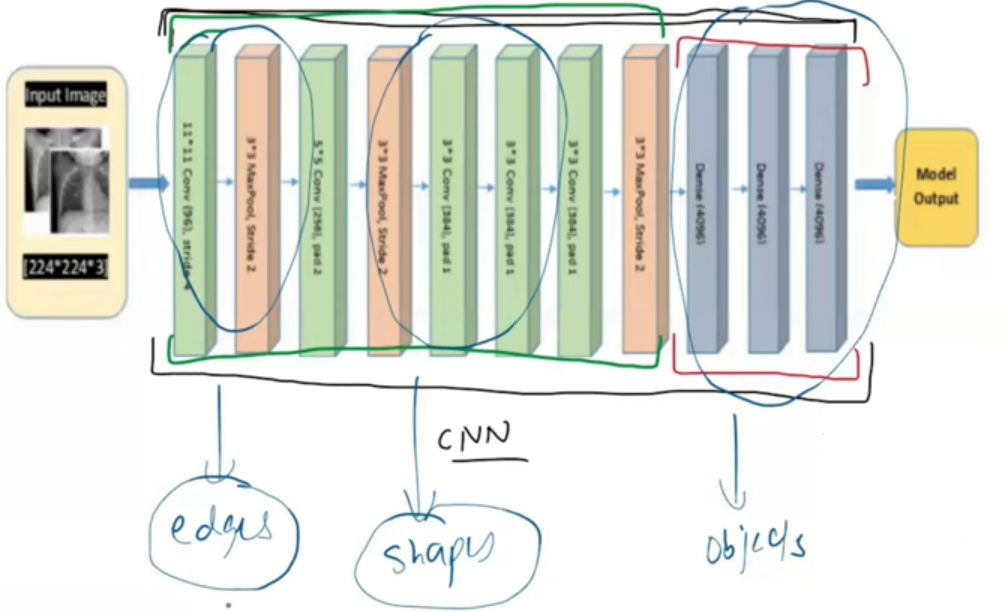

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Lecture Notes & Study Materials/Neural Network & Deeplearning/transfer_learning.png',width=450, height=250)

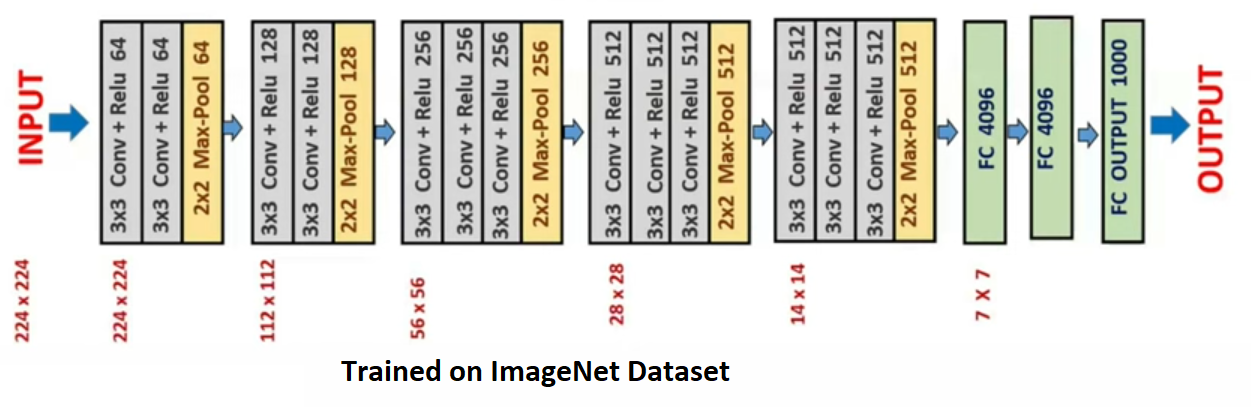

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Lecture Notes & Study Materials/Neural Network & Deeplearning/vgg16_transfer.png',width=700, height=350)

Steps: Import VGG16 --> Remove the Convolutional Part --> Freeze and store--> Train the ANN part using FashionMNIST(No of classes 10) -->Test the performance.

<h4>The inference transforms are available at VGG16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.</h4>
#Expecting a PIL Image
<h4>Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. </h4> # Organized as Batch, Channel, Height & Width

<h4>The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR</h4>

<h4>Followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].</h4>

#So this process brings our FashionMNIST to the correct format, otherwise it wont be accepted.



In [3]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# Convert images to PyTorch tensors and then we normalize pixel values to [-1, 1]
# This is already given for normalization mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), # Add this line to convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),


])

In [5]:
from torch.utils.data import Subset

# Download and load the training dataset
train_dataset = datasets.FashionMNIST(
    root='/content/gdrive/MyDrive/Lecture Notes & Study Materials/Practical Deep Learning using Pytorch/fashion_mnist',     # directory to store the data
    train=True,        # load training data
    download=True,     # download if not already downloaded
    transform=transform  # apply transform
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='/content/gdrive/MyDrive/Lecture Notes & Study Materials/Practical Deep Learning using Pytorch/fashion_mnist',
    train=False,
    download=True,
    transform=transform
)

#Selecting 6000 instances for training
train_dataset= Subset(train_dataset, indices=range(3000))

#Selecting 6000 instances for training
test_dataset= Subset(train_dataset, indices=range(300))


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.08MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]


In [6]:
label_names = [
    "T-shirt/top",  # 0
    "Trouser",      # 1
    "Pullover",     # 2
    "Dress",        # 3
    "Coat",         # 4
    "Sandal",       # 5
    "Shirt",        # 6
    "Sneaker",      # 7
    "Bag",          # 8
    "Ankle boot"    # 9
]

Label Index: 3
It is a: Dress


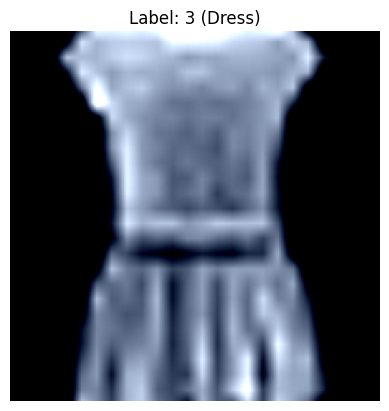

In [7]:
import matplotlib.pyplot as plt

def show_image(index):
    # Get image and label
    img, label = train_dataset[index]

    print("Label Index:", label)
    print("It is a:", label_names[label])

    # Undo normalization: img = (img * std) + mean
    img = img * 0.5 + 0.5  # Since we normalized with mean=0.5, std=0.5

    # Convert to numpy and transpose to (H, W, C)
    img_np = img.numpy().transpose(1, 2, 0)

    # Plot
    plt.imshow(img_np)
    plt.title(f"Label: {label} ({label_names[label]})")
    plt.axis('off')
    plt.show()

show_image(3)

In [8]:
# Wrap datasets in DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
def flatten_image(x):
  return x.view(x.shape[0], -1)

Now Fetching the Pretrained Model VGG16

In [10]:
#Fetching the model

import torchvision.models as models

vgg16=models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


In [11]:
vgg16.features #Same architecture as before

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [12]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [13]:
for param in vgg16.features.parameters():
  param.requires_grad=False
#This indicates no need to update the gradient for the feature or the convolution part. So it has been freezed now.


In [14]:
#Replacing the classifier part with our architecture to map to 10 classes
import torch.nn as nn
vgg16.classifier=nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [15]:
vgg16.classifier #We can observe that the classifer architecture has changed.

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

In [18]:
learning_rate=0.01
epochs=10
vgg16 = vgg16.to(device)
#defining loss
criterion=nn.CrossEntropyLoss()

#defining optimizer
optimizer=torch.optim.SGD(vgg16.parameters(),lr=learning_rate)

In [19]:
#training loop

for epoch in range(epochs):
  total_epoch_loss=0
  for batch_features, batch_labels in train_loader:

    #Moving data to GPU
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    #forward pass
    outputs=vgg16(batch_features) # Move the model to the device

    #calculate loss
    loss=criterion(outputs, batch_labels)

    #backward pass
    optimizer.zero_grad()
    loss.backward()

    #update weights
    optimizer.step()

    total_epoch_loss+=loss.item()

  #printing the average loss
  average_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

Epoch 1/10, Loss: 0.4452560987878353
Epoch 2/10, Loss: 0.4043011427559751
Epoch 3/10, Loss: 0.3715413561526765
Epoch 4/10, Loss: 0.324105662868378
Epoch 5/10, Loss: 0.2937568987303592
Epoch 6/10, Loss: 0.26674557635758783
Epoch 7/10, Loss: 0.2574432460551566
Epoch 8/10, Loss: 0.2323702076014052
Epoch 9/10, Loss: 0.20685118975791525
Epoch 10/10, Loss: 0.19404937469578803


In [21]:
with torch.no_grad():
  correct_predictions=0
  total_samples=0
  for batch_features, batch_labels in test_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    y_pred=vgg16(batch_features)
    for i in range(len(y_pred)):
      temp=torch.argmax(y_pred[i])
      if(temp==batch_labels[i]):
        correct_predictions+=1
      total_samples+=1

  print(f"Accuracy: {correct_predictions/total_samples}")


Accuracy: 0.9633333333333334


Hence it can be observed that through transfer learning we can use powerfull models that are trained on large dataset and simply tune the classifier part for modelling.